# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 10

**Author 1 (sciper):** Sébastien Jeanfavre (269551)  
**Author 2 (sciper):** Badr Larhdir (283205)   
**Author 3 (sciper):** Joe Najm (301560)  

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import cv2 as cv
import numpy as np
from skimage import morphology
from skimage.feature import canny
from scipy.ndimage.morphology import binary_fill_holes


data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

In [2]:
def display_image(mat, axes=None, cmap=None, hide_axis=True):
    """
    Display a given matrix into Jupyter's notebook
    
    :param mat: Matrix to display
    :param axes: Subplot on which to display the image
    :param cmap: Color scheme to use
    :param hide_axis: If `True` axis ticks will be hidden
    :return: Matplotlib handle
    """
    img = cv2.cvtColor(mat, cv2.COLOR_BGR2RGB) if mat.ndim == 3 else mat
    cmap= cmap if mat.ndim != 2 or cmap is not None else 'gray'
    if axes is None:
        if hide_axis:
            plt.xticks([])
            plt.yticks([])
        return plt.imshow(img, cmap=cmap)
    else:
        if hide_axis:
            axes.set_xticks([])
            axes.set_yticks([])
        return axes.imshow(img, cmap=cmap)

### 1.1 Brain image visualization

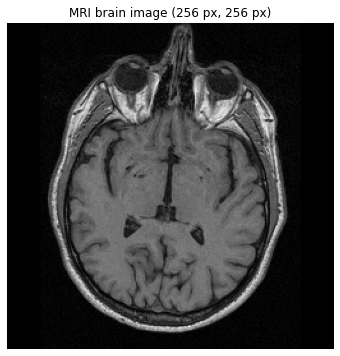

In [3]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

In [4]:
def region_growing(image, seg_img, t_low, t_high, seed):   
    seeds = [seed]
    seg_img[seed[0],seed[1]] = 255
    while(len(seeds) > 0):
        seed = seeds.pop(0)
        x = seed[0]
        y = seed[1]
        for i in range(-1,2):
            for j in range(-1,2):
                if(i == 0 and j == 0):
                    continue
                if (image[x+i,y+j] > t_low and image[x+i,y+j] < t_high):
                    if seg_img[x+i,y+j] == 0:                              #check if we did not already considered this point
                        seg_img[x+i,y+j] = 255
                        seeds.append([x+i,y+j])
                        
                
    return seg_img

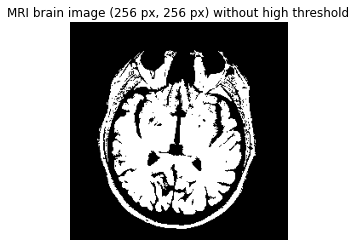

There are 21135 pixels on the brain using the Region Growing method without high threshold


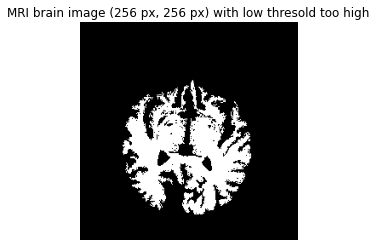

There are 11529 pixels on the brain using the Region Growing method with low thresold too high


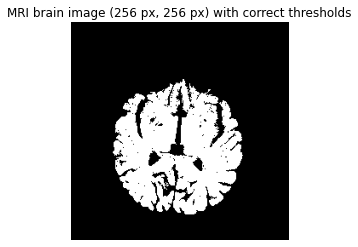

There are 15191 pixels on the brain using the Region Growing method with correct thresholds


In [5]:
seg_img = np.zeros(np.shape(brain_im))
img =  region_growing(brain_im, seg_img, 60, 255, [128,100])

plt.figure()
plt.imshow(img, cmap='gray')
plt.title('MRI brain image ({} px, {} px) without high threshold'.format(im_h, im_w))
plt.axis('off')
plt.show()
print(f"There are {int(np.sum(img)/255)} pixels on the brain using the Region Growing method without high threshold")


seg_img = np.zeros(np.shape(brain_im))
img =  region_growing(brain_im, seg_img, 70, 255, [128,100])

plt.figure()
plt.imshow(img, cmap='gray')
plt.title('MRI brain image ({} px, {} px) with low thresold too high'.format(im_h, im_w))
plt.axis('off')
plt.show()
print(f"There are {int(np.sum(img)/255)} pixels on the brain using the Region Growing method with low thresold too high")

seg_img = np.zeros(np.shape(brain_im))
img =  region_growing(brain_im, seg_img, 60, 96, [128,100])

plt.figure()
plt.imshow(img, cmap='gray')
plt.title('MRI brain image ({} px, {} px) with correct thresholds'.format(im_h, im_w))
plt.axis('off')
plt.show()
print(f"There are {int(np.sum(img)/255)} pixels on the brain using the Region Growing method with correct thresholds")

We fixed a high threshold in addition to the low threshold to remove the small white link between the brain and the right eye that would make the region growing algorithm consider all the skull as well. Taking some good thresold values, we finally obtain a good brain image with 15191 pixels. We also notice that the previous images with bad threshold values either yield to too small and incomplete brains or to an image with the skull as well

### 1.3 Contour detection (5pts)

These are the steps that we have done in order to detect the contour of the brain from the brain MRI. First, we must detect the edges. By blurring the image, applying the Laplacian of this blurred image then thresholding it, we obtain the saturated edges of the image. Moreover, by applying successively multiple advanced morphological transformations such as MORPH_CLOSE, MORPH_OPEN and MORPH_ERODE, we obtain a smoothened version of our image without any obstructive noise. After that we find the contours of the newly cleaned image. By sorting the area of the contours and superposing (by filling) the main interesting ones we get a very sharp contour of our brain.

In [6]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

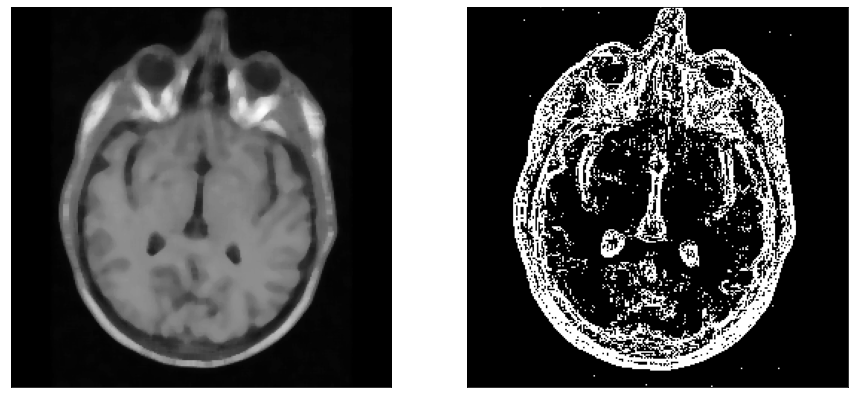

In [7]:
blurred_brain = cv.medianBlur(brain_im, 7)
brain_cont = cv.convertScaleAbs(cv.Laplacian(blurred_brain, cv.CV_16S, ksize=3))
_, brain_cont = cv.threshold(brain_cont, 13, 255, cv.THRESH_BINARY)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
display_image(blurred_brain);
plt.subplot(1,2,2)
display_image(brain_cont);

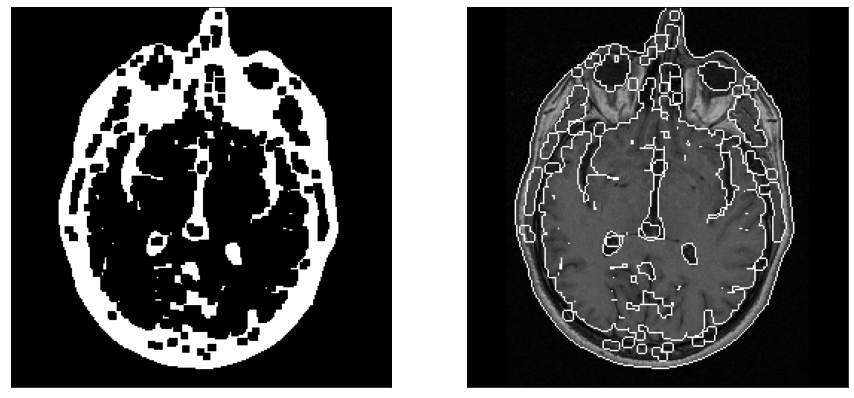

In [11]:
# Initializing the 3x3 kernel (performs better than the 2x2 and 4x4 being respectively too small or too big for the image we have)
ker = cv.getStructuringElement(cv.MORPH_RECT,(3,3))

# Applying multiple morphological transformations to the brain contour image
brain_cont_morph_close = cv.morphologyEx(brain_cont, cv.MORPH_CLOSE , ker)
brain_cont_morph_open = cv.morphologyEx(brain_cont_morph_close, cv.MORPH_OPEN , ker)
brain_cont_morph = cv.morphologyEx(brain_cont_morph_open, cv.MORPH_ERODE , ker)

_, contours, hierarchy = cv.findContours(brain_cont_morph, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
brain_contoured = cv.drawContours(brain_im, contours, -1, [255,255,255])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
display_image(brain_cont_morph);
plt.subplot(1,2,2)
display_image(brain_contoured);

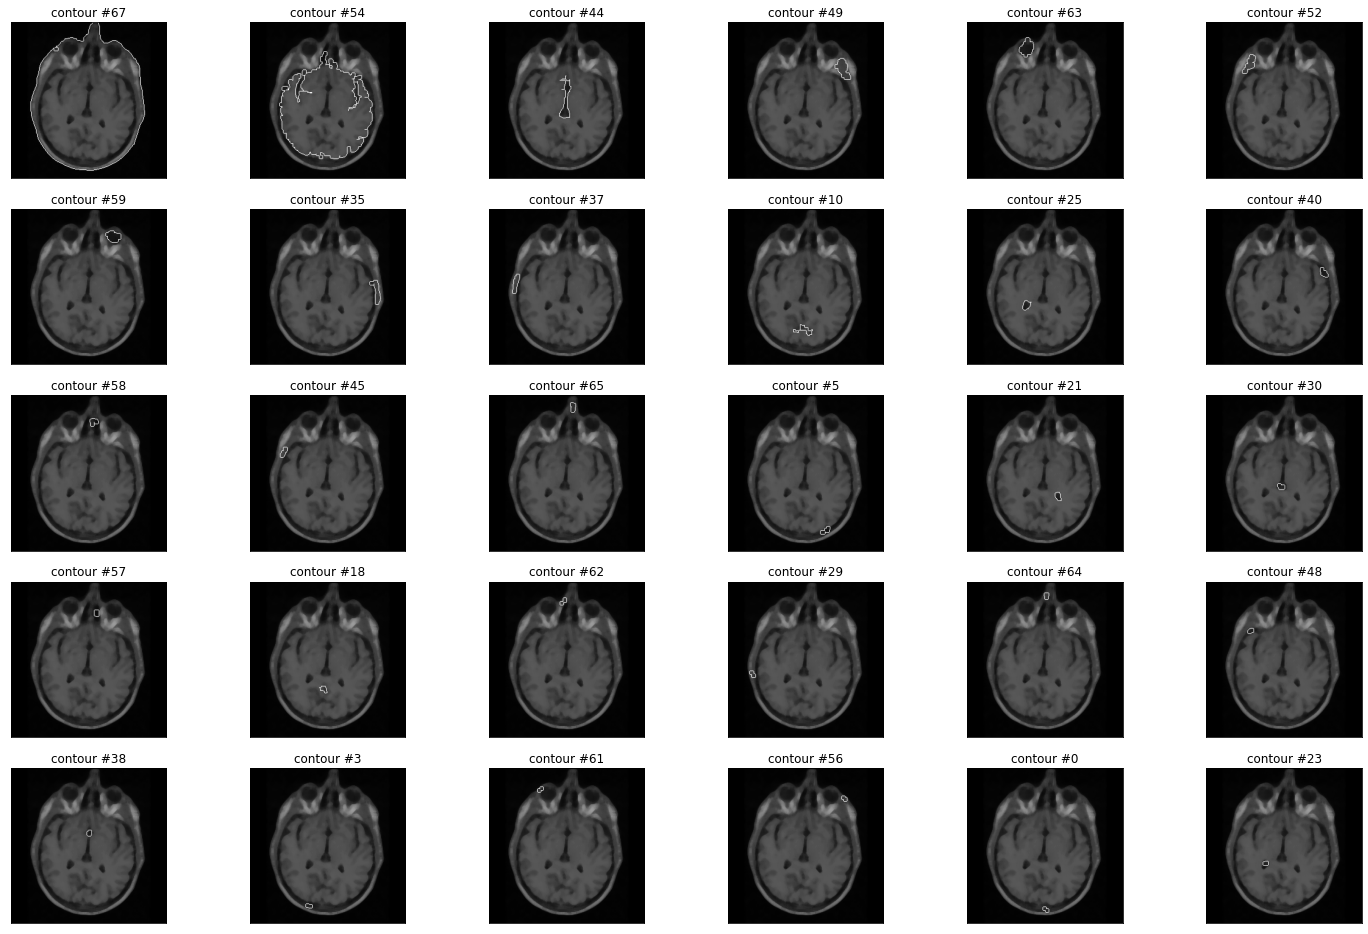

In [12]:
# We compute areas for each contour found
contours_area = []
for idx, contour in enumerate(contours):
    contours_area.append([cv.contourArea(contour), idx])
    
# We sort from the highest to the lowest of the contours area
contours_area.sort(reverse=True)

plt.figure(figsize = (25,20))
for idx, contour in enumerate(contours_area[:30]):
    contour_brain = blurred_brain.copy()
    contour_brain = cv.fillPoly(contour_brain, contours[contour[1]], [255,255,255])

    plt.subplot(6,6, idx + 1)
    plt.title(f"contour #{contour[1]}")
    display_image(contour_brain);

# We extract the interesting contour indices from the plot to fill our blurred brain with those contours area
idx_interesting_contours = [54, 44, 25, 21, 10, 18]

contour_filled = blurred_brain.copy()
for idx in idx_interesting_contours:
     contour_filled = cv.fillPoly(contour_filled, contours[idx], [255,255,255])

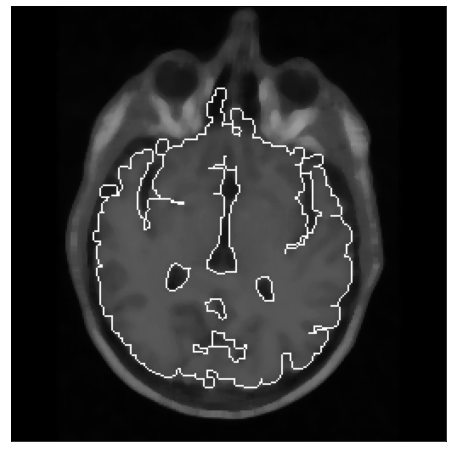

In [13]:
plt.figure(figsize = (8,8))
display_image(contour_filled);

### 1.4 Additional method (5pts)

For the additional method we opted to use the Canny filter to find the contour of the brain.
In order to find the contour, we have initialize manually masks that circles the whole brain, we tried to use two cicle masks, one a little bigger than the order to make sure that the whole brain is included in the cicle when we do the edge detection with our Canny filter.

We then overlap the biggest mask with the brain image then find the edges of this image with the smallest mask. When the edges are found we applying a morphological transformations to dilate the canny filter ( to connect some of small edges that should be connected ).Moreover, we fill the holes of the filter to get some missing parts of the brain then we transform it into our new mask with an AND operation with the previous brain mask. Finally we remove the fine parts that are out of the brain region.

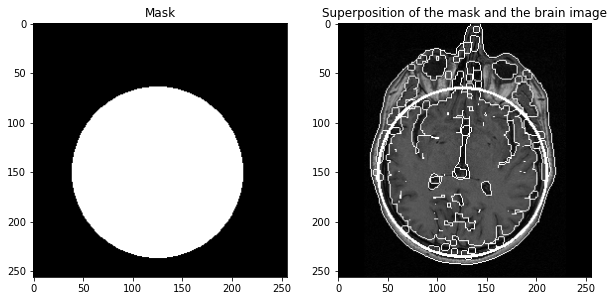

In [14]:
# Circle Masks intialization
circle_excess_brain = cv.circle(np.zeros_like(brain_im),(125,150), 85,(255,255,255),2)
excess_brain_mask = binary_fill_holes(circle_excess_brain).astype(np.uint8)

circle_brain = cv.circle(np.zeros_like(brain_im),(125,150),80,(255,255,255),2)
brain_mask = binary_fill_holes(circle_brain).astype(np.uint8)

# Overlapping the mask and the brain image
brain_with_circle = circle_excess_brain | brain_im

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].set_title("Mask")
ax[0].imshow(excess_brain_mask,cmap='gray');
ax[1].set_title("Superposition of the mask and the brain image")
ax[1].imshow(brain_with_circle , cmap='gray');

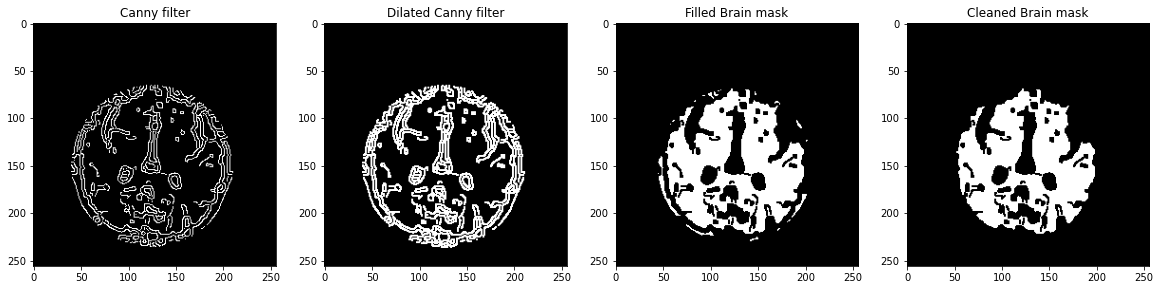

In [15]:
# Finding the edges of the brain image using the mask defined previously
canny_im = canny(brain_im, sigma=1.3, mask = excess_brain_mask.astype(bool)).astype(np.uint8)

# Applying a morphological transformations to dilate the canny filter ( to connect some edges )
canny_edge = cv.morphologyEx(canny_im, cv.MORPH_DILATE, np.ones((2,2), np.uint8), iterations = 1)

# Filling the holes of the filter to get some missing parts of the brain, then AND operation with the brain mask
masked_im = ( 1 -  binary_fill_holes(canny_edge).astype(np.uint8) ) & brain_mask

# Removing the fine parts that are out of the brain region
cleaned_masked_im = morphology.remove_small_objects(masked_im.astype(bool), min_size = 1300).astype(np.uint8)

fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].set_title("Canny filter")
ax[0].imshow(canny_im ,cmap='gray');
ax[1].set_title("Dilated Canny filter")
ax[1].imshow(canny_edge , cmap='gray');
ax[2].set_title("Filled Brain mask")
ax[2].imshow(masked_im , cmap='gray')
ax[3].set_title("Cleaned Brain mask")
ax[3].imshow(cleaned_masked_im , cmap='gray');

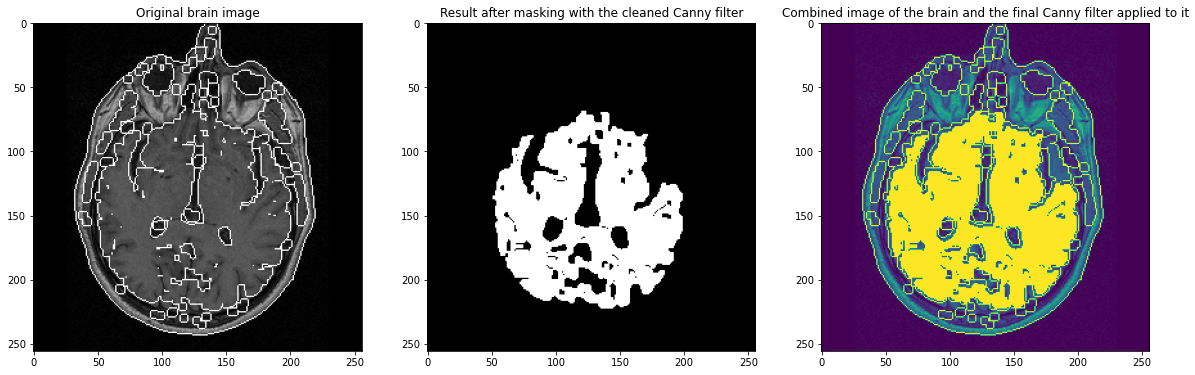

In [16]:
masked_im = cv.morphologyEx(cleaned_masked_im, cv.MORPH_DILATE, np.ones((2,3), np.uint8), iterations = 1) * 255
combined_im = brain_im | masked_im

fig, ax = plt.subplots(1, 3, figsize=(20, 15))
ax[0].set_title("Original brain image")
ax[0].imshow(brain_im, cmap='gray')
ax[1].set_title("Result after masking with the cleaned Canny filter")
ax[1].imshow(masked_im, cmap='gray')
ax[2].set_title("Combined image of the brain and the final Canny filter applied to it")
ax[2].imshow(combined_im);

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [17]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


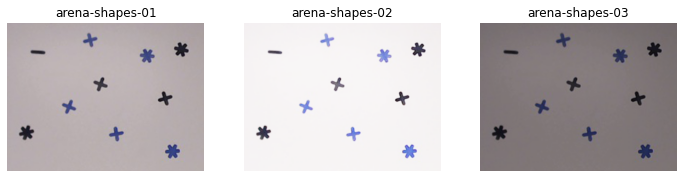

In [18]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [19]:
# Convert images to from RGBHSV
images_HSV = np.array([cv.cvtColor(im, cv.COLOR_RGB2HSV) for im in images])
images_HSV.shape


(3, 480, 640, 3)

In [20]:
# We use the rescale_intensity function from skimage to rescale the value 
# channel of each image to make the process invariant to illumination changes
from skimage.exposure import rescale_intensity

images_HSV_eq = images_HSV.copy()
images_HSV_eq[0,:,:,2] = rescale_intensity(images_HSV[0,:,:,2])
images_HSV_eq[1,:,:,2] = rescale_intensity(images_HSV[1,:,:,2])
images_HSV_eq[2,:,:,2] = rescale_intensity(images_HSV[2,:,:,2])

In [21]:
# Convert back rescaled images back to RBG
images_RGB_eq = np.array([cv.cvtColor(im, cv.COLOR_HSV2RGB) for im in images_HSV_eq])

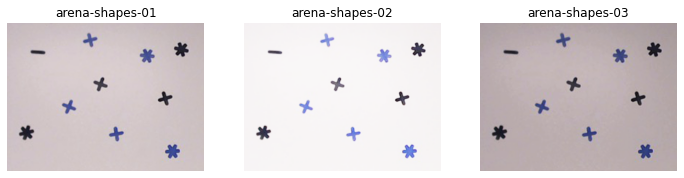

In [22]:
# Plot rescaled images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images_RGB_eq, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

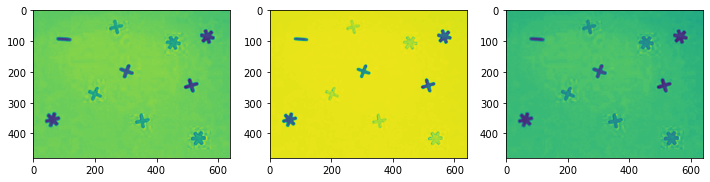

In [23]:
# Plot the blue channel of each image
fig, ax = plt.subplots(1, 3, figsize=(12,12))
ax[0].imshow(images_RGB_eq[0,:,:,2])
ax[1].imshow(images_RGB_eq[1,:,:,2])
ax[2].imshow(images_RGB_eq[2,:,:,2])
plt.show()

In [24]:
# Remove small clusters that are considered as labels but are unwanted 
# (if size in pixels smaller than certain threshold)

def remove_noise(noisy_image,threshold):

    label_img_new = np.copy(noisy_image)
    num_comp = np.amax(noisy_image)
    final_num_comp = -1  # Start from -1 because we loop until num_comp + 1
    
    for i in range(num_comp+1):
        num_pixels = sum(sum(noisy_image==i))
        final_num_comp += 1
        if num_pixels < threshold:
            label_img_new[noisy_image==i] = 0
            final_num_comp -= 1
    
    return final_num_comp, label_img_new

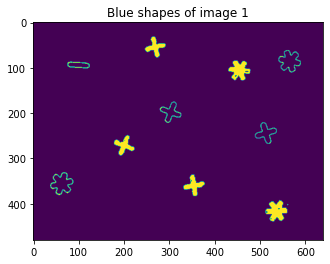

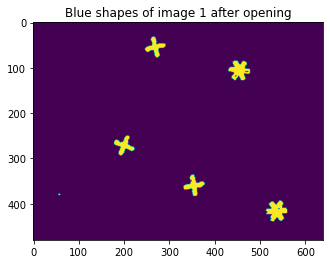

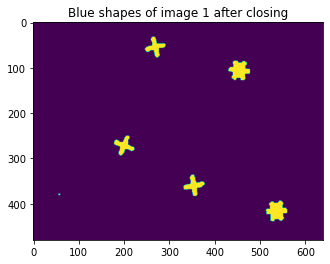

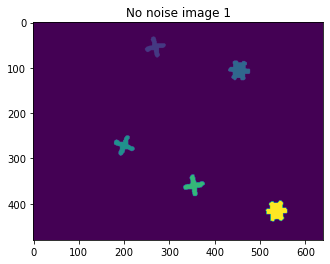

There are 5 blue shapes in image 1


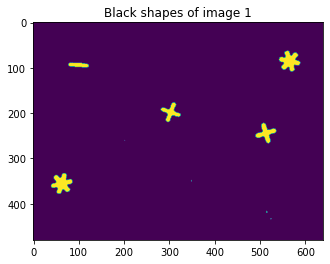

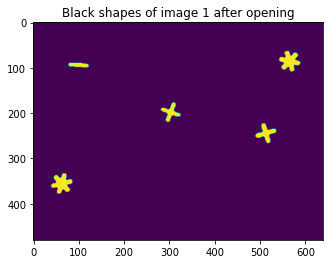

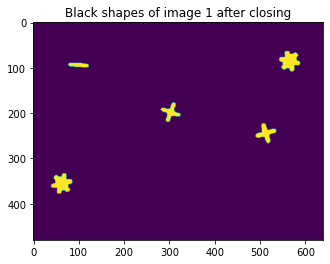

There are 5 black shapes in image 1


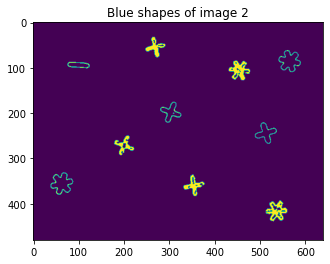

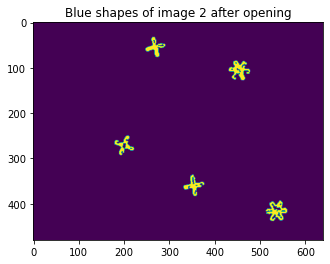

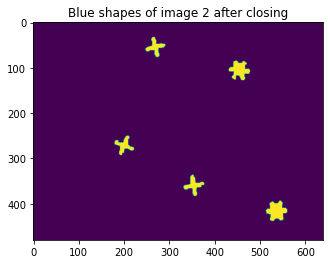

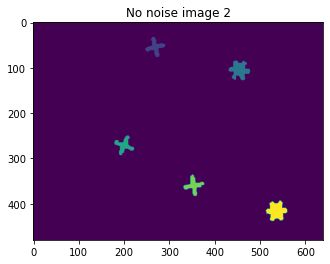

There are 5 blue shapes in image 2


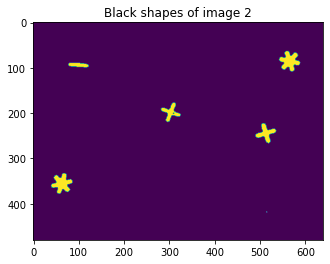

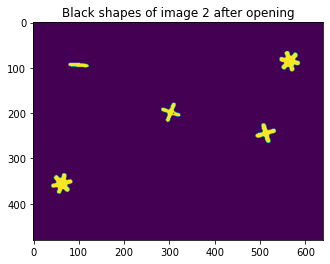

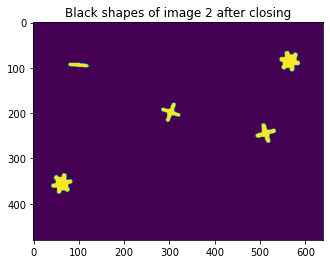

There are 5 black shapes in image 2


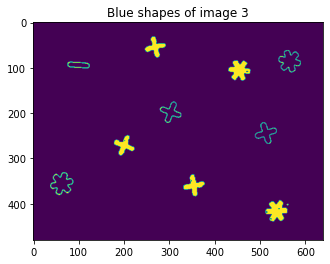

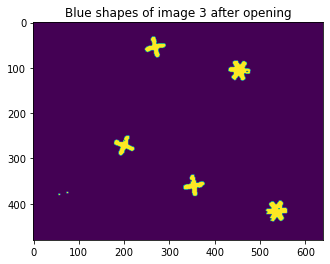

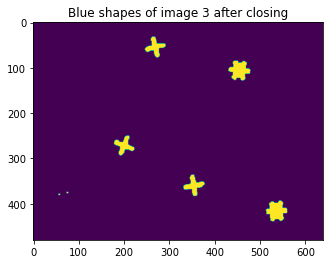

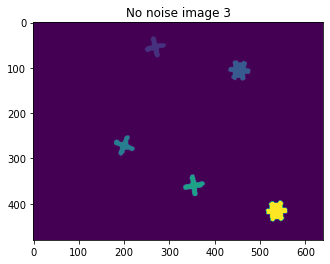

There are 5 blue shapes in image 3


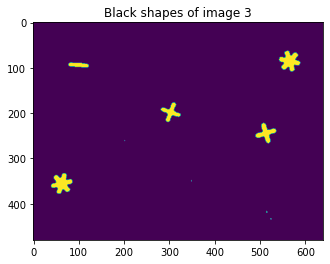

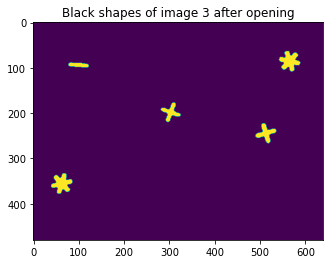

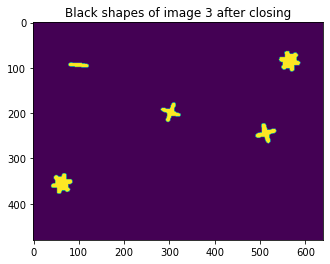

There are 5 black shapes in image 3


In [25]:
from skimage.filters import threshold_multiotsu
from skimage.morphology import binary_closing, binary_opening, square
from skimage import measure

total_area_blue = np.zeros(3)
total_area_black = np.zeros(3)

# We loop over the 3 images to compute the number of colored shapes and area in pixels of each color 
for i in range(3):
    im = images_RGB_eq[i,:,:,2]

    threshold = threshold_multiotsu(im) # Find 2 threshold to separate the background, blue and black shapes
    
    blue_shapes = np.zeros(im.shape)    
    blue_mask = ((im < threshold[1]) & (im > threshold[0]))   # Create mask to keep only blue shapes
    blue_shapes[blue_mask] = 1
    
    plt.figure()
    plt.imshow(blue_shapes)
    plt.title("Blue shapes of image " + str(i+1))
    plt.show()
    
    opened_blue_shapes = binary_opening(blue_shapes, square(3))  # Remove unwanted contours of blue shapes
    plt.figure()
    plt.imshow(opened_blue_shapes)
    plt.title("Blue shapes of image " + str(i+1) + " after opening")
    plt.show()
    
    closed_blue_shapes = binary_closing(opened_blue_shapes, square(7))  # Fill up missing bits of shapes
    plt.figure()
    plt.imshow(closed_blue_shapes)
    plt.title("Blue shapes of image " + str(i+1) + " after closing")
    plt.show()
        
    labels = measure.label(closed_blue_shapes)    # Create label map of blue shapes
    num_comp, no_noise_blue = remove_noise(labels,100)   # Remove the small points on bottom without impacting the big shapes
    
    plt.figure()
    plt.imshow(no_noise_blue)
    plt.title(f"No noise image {i+1}")
    plt.show()
    
    print(f"There are {num_comp} blue shapes in image {i+1}")
    
    total_area_blue[i] = np.sum(no_noise_blue)

    
    black_shapes = np.zeros(im.shape)
    
    black_mask = (im <= threshold[0]) # Create mask to keep only black shapes
    black_shapes[black_mask] = 1
    
    plt.figure()
    plt.imshow(black_shapes)
    plt.title("Black shapes of image " + str(i+1))
    plt.show()
    
    opened_black_shapes = binary_opening(black_shapes, square(3)) # Remove unwanted contours of black shapes
    plt.figure()
    plt.imshow(opened_black_shapes)
    plt.title("Black shapes of image " + str(i+1) + " after opening")
    plt.show()
    
    closed_black_shapes = binary_closing(opened_black_shapes, square(7)) # Fill up missing bits of shapes
    plt.figure()
    plt.imshow(closed_black_shapes)
    plt.title("Black shapes of image " + str(i+1) + " after closing")
    plt.show()
    
    labels = measure.label(closed_black_shapes)   # No need to use remove_noise function for black shapes as there is no noise
    num_comp = np.amax(labels)                    # Count number of labels
    print(f"There are {num_comp} black shapes in image {i+1}")
    
    total_area_black[i] = np.sum(closed_black_shapes)


### 2.3 Total area (in pixels) of each color (5 pts)

The computation of the number of pixels in each image was done above by looking at the number of labels generated by the label map of skimage measure using the denoised final image

In [26]:
print(f"There are {total_area_blue[0]} pixels of blue in image 1")
print(f"There are {total_area_blue[1]} pixels of blue in image 2")
print(f"There are {total_area_blue[2]} pixels of blue in image 3")

print(f"There are {total_area_black[0]} pixels of black in image 1")
print(f"There are {total_area_black[1]} pixels of black in image 2")
print(f"There are {total_area_black[2]} pixels of black in image 3")

There are 17853.0 pixels of blue in image 1
There are 14967.0 pixels of blue in image 2
There are 19610.0 pixels of blue in image 3
There are 4432.0 pixels of black in image 1
There are 4238.0 pixels of black in image 2
There are 4445.0 pixels of black in image 3
